<a href="https://colab.research.google.com/github/sg-peytrignet/algeria24-training/blob/main/4_cost_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cost analysis

## Setting up our environment

We import Python libraries needed for our cost analysis:

- Data tools (pandas, numpy) for calculations
- Geographic tools (geopandas) for mapping
- Visualization libraries (matplotlib, folium, seaborn) for creating graphs and maps

These will help us analyze and visualize the costs of different connectivity options.

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Graph and spatial libraries
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Notebook interaction and display
import ipywidgets as widgets
from IPython.display import display

The option `display_folium` controls whether to display interactive maps, which can be heavy and prevent the markdown file from displaying correctly.

In [22]:
display_folium = True

## Set analysis parameters

We create an interactive interface to set important cost variables for different connection technologies (Fiber, Cellular, Point-to-Point, and Satellite). For each technology, we can adjust:

- **CAPEX**: One-time installation costs (equipment, setup)
- **OPEX**: Ongoing yearly costs (maintenance, service fees)
- **ARPU**: Annual Revenue Per User (expected income per person)

We also set the **maximum fiber cable length** per school and **analysis timeframe**.

In [3]:
# @title Cost parameters
# Common layout for all widgets
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

# Parameters for each technology
technologies = ['Fiber', 'Cellular', 'P2P', 'Satellite']
tech_controls = {}
for tech in technologies:
    tech_controls[tech] = {
        'CAPEX': widgets.FloatSlider(
            description=f'One-off CAPEX (USD):',
            min=0,
            max=10000,
            step=1000,
            value=1000,
            layout=item_layout,
            style={'description_width': 'initial'},
            readout_format=',.0f'
        ),
        'OPEX': widgets.FloatSlider(
            description=f'Annual OPEX (USD):',
            min=0,
            max=5000,
            step=500,
            value=500,
            layout=item_layout,
            style={'description_width': 'initial'},
            readout_format=',.0f'
        ),
        'ARPU': widgets.FloatSlider(
            description=f'Annual revenue per user (USD):',
            min=0,
            max=100,
            step=1,
            value=50,
            layout=item_layout,
            style={'description_width': 'initial'},
            readout_format=',.0f'

        )
    }

# Overall parameters
max_fiber_length = widgets.FloatSlider(
    description='Maximum Fiber Length (km):',
    min=0,
    max=15,
    step=1,
    value=1,
    layout=item_layout,
    style={'description_width': 'initial'},
    readout_format=',.0f'
)

num_years = widgets.IntSlider(
    description='Number of years:',
    min=1,
    max=50,
    step=1,
    value=10,
    layout=item_layout,
    style={'description_width': 'initial'},
    readout_format=',.0f'
)

# Arrange controls in a layout
tech_layouts = []
for tech, controls in tech_controls.items():
    tech_layouts.append(
        widgets.VBox(
            [widgets.HTML(value=f"<b>{tech}</b>")] +
            [controls[param] for param in controls],
            layout=widgets.Layout(justify_content='space-between')
        )
    )

overall_layout = widgets.VBox(
    [widgets.HTML(value='<b>Overall Parameters</b>'), max_fiber_length, num_years],
    layout=widgets.Layout(justify_content='space-between')
)

inputs_layout = widgets.VBox(
    children= [overall_layout] + tech_layouts
)

display(inputs_layout)

## Get results from previous analyses

We load previously calculated data about schools:

- Proximity data: distances to existing infrastructure
- Coverage data: which areas have cellular service
- Visibility data: line-of-sight between schools and towers
- Population data: number of potential users near each school

This gives us the foundation for our revenue and cost calculations.

### Proximity, coverage and demand analysis

In [4]:
pcd_results = pd.read_csv('https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/results/algeria-results-pcd.csv')
pcd_results = pcd_results.set_index('poi_id')

In [5]:
algeria_schools_gdf = gpd.GeoDataFrame(pcd_results, geometry=gpd.points_from_xy(pcd_results.lon, pcd_results.lat), crs='EPSG:4326')
algeria_schools_gdf =  algeria_schools_gdf[["geometry"]]

### Visibility analysis

In [6]:
visibility_results = pd.read_csv('https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/results/algeria-results-visibility.csv')
visibility_results.set_index('poi_id', inplace=True)

### Merge results

In [7]:
merged_results = pcd_results[["coverage","transmission_node_distance","population_in_buffer"]].merge(visibility_results[["is_visible"]], left_index=True, right_index=True)

In [8]:
merged_results.head()

,coverage,transmission_node_distance,population_in_buffer,is_visible
poi_id,,,,
8dd444f0-2eb1-4d9a-bf57-f032e51768e0,False,60679.529620,99.005241,False
a1c86f79-a20e-4001-9ac0-def0831024f1,False,57250.907515,173.087494,False
cb814cd6-0c90-49d6-b847-d163a95e77e0,False,61309.775174,56.801067,False
194188d3-94b1-4e03-a002-25e8c868bfae,False,61303.976752,27.561897,False
c32d3c71-c574-4701-b761-ec757dbe2d4f,True,98632.546164,1083.468872,False


## Assess feasibility of technologies for each school

We determine which connection technologies are possible for each school based on:

- **Fiber**: Is it close enough to existing fiber networks?
- **Cellular**: Is it in an area with coverage?
- **Point-to-Point**: Does it have line-of-sight to towers?
- **Satellite**: Always feasible, but often more expensive.

This helps eliminate impossible options before cost analysis.

In [9]:
feasibility = merged_results.copy()
feasibility["fiber_feasible"] = feasibility["transmission_node_distance"] <= max_fiber_length.value*1000
feasibility["p2mp_feasible"] = feasibility["coverage"]
feasibility["p2p_feasible"] = feasibility["is_visible"]
feasibility["satellite_feasible"] = True
feasibility = feasibility[["fiber_feasible","p2mp_feasible","p2p_feasible","satellite_feasible"]]

In [10]:
feasibility.head()

,fiber_feasible,p2mp_feasible,p2p_feasible,satellite_feasible
poi_id,,,,
8dd444f0-2eb1-4d9a-bf57-f032e51768e0,False,False,False,True
a1c86f79-a20e-4001-9ac0-def0831024f1,False,False,False,True
cb814cd6-0c90-49d6-b847-d163a95e77e0,False,False,False,True
194188d3-94b1-4e03-a002-25e8c868bfae,False,False,False,True
c32d3c71-c574-4701-b761-ec757dbe2d4f,False,True,False,True


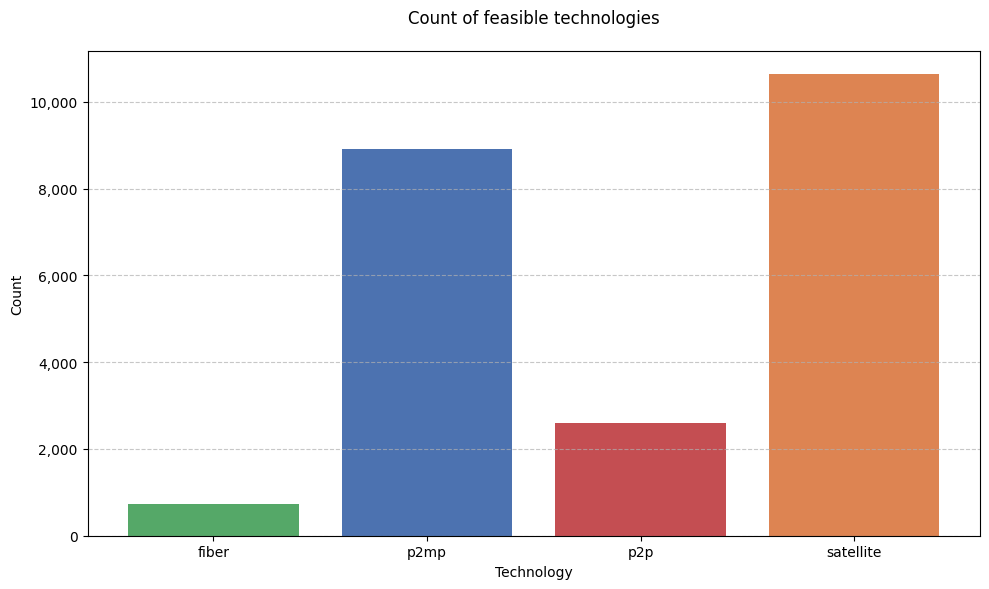

In [11]:
# Create feasibility counts for bar chart
feasibility_counts = {
   'fiber': feasibility['fiber_feasible'].sum(),
   'p2mp': feasibility['p2mp_feasible'].sum(),
   'p2p': feasibility['p2p_feasible'].sum(),
   'satellite': feasibility['satellite_feasible'].sum()
}
color_map = {
   'p2mp': '#4C72B0',
   'satellite': '#DD8452',
   'fiber': '#55A868',
   'p2p': '#C44E52'
}
plt.figure(figsize=(10, 6))
technologies = list(feasibility_counts.keys())
counts = list(feasibility_counts.values())
colors = [color_map[tech] for tech in technologies]
plt.bar(technologies, counts, color=colors)
plt.title('Count of feasible technologies', pad=20)
plt.xlabel('Technology')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

## Compute operator revenues for each school and technology

For each feasible technology at each school, we calculate potential revenue:

Total Revenue = (Annual Revenue per User × Number of Users × Years) -
                (One-time Costs + Annual Costs × Years)

This shows which technologies might be profitable for service providers

In [12]:
revenues = merged_results.copy()
revenues["fiber_revenue"] = tech_controls["Fiber"]["ARPU"].value*merged_results["population_in_buffer"]*num_years.value-tech_controls["Fiber"]["CAPEX"].value-tech_controls["Fiber"]["OPEX"].value*num_years.value
revenues["p2mp_revenue"] = tech_controls["Cellular"]["ARPU"].value*merged_results["population_in_buffer"]*num_years.value-tech_controls["Cellular"]["CAPEX"].value-tech_controls["Cellular"]["OPEX"].value*num_years.value
revenues["p2p_revenue"] = tech_controls["P2P"]["ARPU"].value*merged_results["population_in_buffer"]*num_years.value-tech_controls["P2P"]["CAPEX"].value-tech_controls["P2P"]["OPEX"].value*num_years.value
revenues["satellite_revenue"] = tech_controls["Satellite"]["ARPU"].value*merged_results["population_in_buffer"]*num_years.value-tech_controls["Satellite"]["CAPEX"].value-tech_controls["Satellite"]["OPEX"].value*num_years.value
revenues = revenues[["fiber_revenue","p2mp_revenue","p2p_revenue","satellite_revenue"]]

In [13]:
# Set cost to missing if technology is not feasible
for tech in ['fiber', 'p2mp', 'p2p', 'satellite']:
    revenues.loc[~feasibility[f'{tech}_feasible'], f'{tech}_revenue'] = np.nan

In [14]:
revenues.head()

,fiber_revenue,p2mp_revenue,p2p_revenue,satellite_revenue
poi_id,,,,
8dd444f0-2eb1-4d9a-bf57-f032e51768e0,NaN,NaN,NaN,43502.620697
a1c86f79-a20e-4001-9ac0-def0831024f1,NaN,NaN,NaN,80543.746948
cb814cd6-0c90-49d6-b847-d163a95e77e0,NaN,NaN,NaN,22400.533676
194188d3-94b1-4e03-a002-25e8c868bfae,NaN,NaN,NaN,7780.948639
c32d3c71-c574-4701-b761-ec757dbe2d4f,NaN,535734.436035,NaN,535734.436035


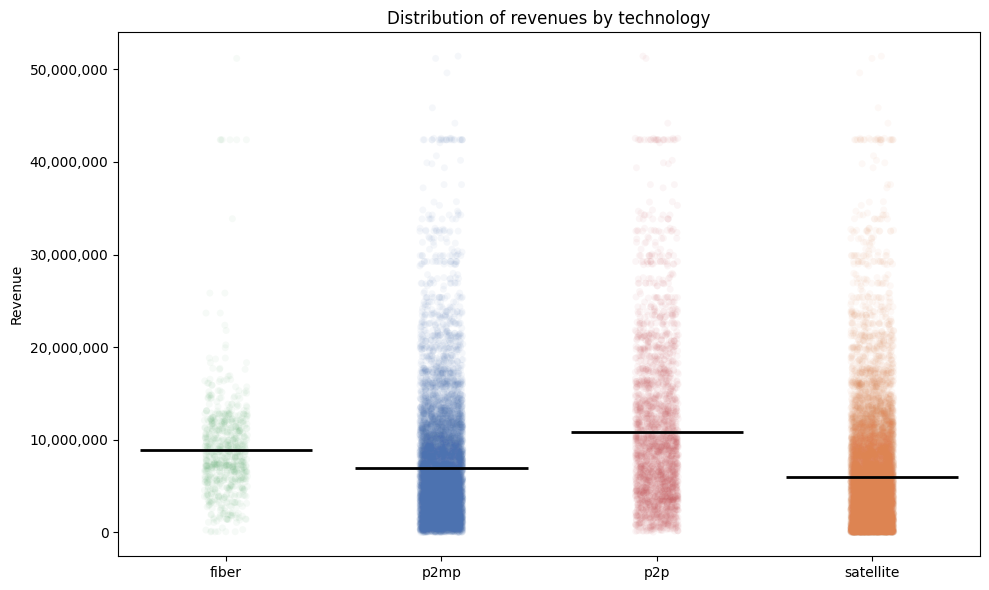

In [15]:
# Box plot of revenues by technology
data = revenues[['fiber_revenue', 'p2mp_revenue', 'p2p_revenue', 'satellite_revenue']].melt(
   var_name='Technology',
   value_name='Revenue'
)
data['Technology'] = data['Technology'].str.replace('_revenue', '')
plt.figure(figsize=(10, 6))
sns.boxplot(x='Technology', y='Revenue', data=data, palette=color_map, hue='Technology',
            showfliers=False, showbox=False, showcaps=False, showmeans=True, meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10)

sns.stripplot(x='Technology', y='Revenue', data=data, alpha=0.05, jitter=True, palette=color_map, hue='Technology')
plt.xlabel('')
plt.ylabel('Revenue')
plt.title('Distribution of revenues by technology')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

## Assign a technology to each school by maximizing operator revenue

We choose the best technology for each school by:

1. Considering only feasible options
2. Selecting the technology with highest potential revenue
3. Marking schools where no profitable options exist

This helps identify the most economically viable connection method for each school.

In [16]:
# Find highest revenue for each row
revenue_cols = ['fiber_revenue', 'p2mp_revenue', 'p2p_revenue', 'satellite_revenue']
revenues['selected_technology'] = revenues[revenue_cols].idxmax(axis=1).str.replace('_revenue', '')
# If all revenues are NaN, set selected_technology to NaN
mask = revenues[revenue_cols].isna().all(axis=1)
revenues.loc[mask, 'selected_technology'] = np.nan

<ipython-input-16-96e17114546e>:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  revenues['selected_technology'] = revenues[revenue_cols].idxmax(axis=1).str.replace('_revenue', '')


## Visualize the technology assignment

We create two main visualizations:

1. Bar Chart: Shows how many schools are assigned to each technology
2. Interactive Map: Displays schools color-coded by their assigned technology

### Bar chart

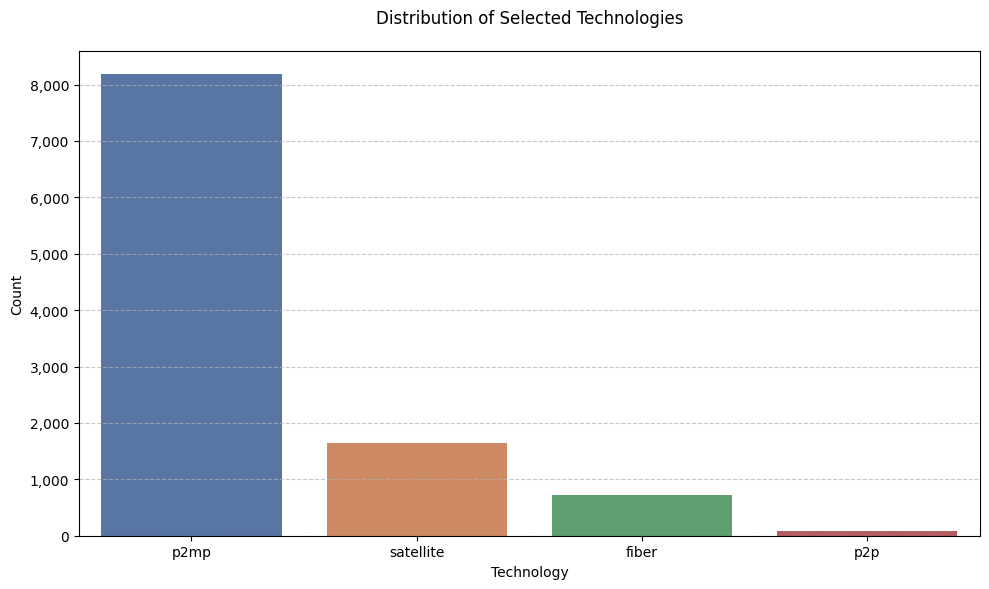

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(data=revenues["selected_technology"].value_counts().reset_index(),
           x="selected_technology",
           y="count",
           palette=color_map,
           hue="selected_technology")
plt.title('Distribution of Selected Technologies', pad=20)
plt.xlabel('Technology')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

### Map

In [18]:
def plot_points_by_technology(points_gdf, color_map, title="Points by Technology", zoom=6):
    """
    Create an interactive map with points colored by selected technology
    """
    if points_gdf.crs != "EPSG:4326":
        points_gdf = points_gdf.to_crs("EPSG:4326")

    center_lat = points_gdf.geometry.y.mean()
    center_lon = points_gdf.geometry.x.mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom)

    title_html = f'''
    <div style="position: fixed;
                top: 10px;
                left: 50px;
                z-index: 1000;
                background-color: white;
                padding: 10px;
                border-radius: 5px;">
        <h4>{title}</h4>
        Total Points: {len(points_gdf)}
    </div>
    '''

    legend_html = '''
    <div style="position: fixed;
                bottom: 50px;
                right: 50px;
                z-index: 1000;
                background-color: white;
                padding: 10px;
                border-radius: 5px;">
    <p><strong>Technologies</strong></p>
    '''

    for tech, color in color_map.items():
        legend_html += f'<p><span style="color:{color}">●</span> {tech}</p>'

    legend_html += '</div>'

    m.get_root().html.add_child(folium.Element(title_html))
    m.get_root().html.add_child(folium.Element(legend_html))

    for _, row in points_gdf.iterrows():
        color = color_map.get(row.selected_technology, '#808080')  # gray for NaN
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            color='black',
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"ID: {row.name}<br>Technology: {row.selected_technology}"
        ).add_to(m)

    return m

In [19]:
algeria_schools_gdf = algeria_schools_gdf.merge(revenues["selected_technology"], left_index=True, right_index=True).dropna(subset=["selected_technology"])

In [23]:
if display_folium:
  plot_points_by_technology(algeria_schools_gdf, color_map, title="Schools by Selected Technology", zoom=6)